In [3]:
from osgeo import gdal
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as osp
import csv
import data

In [28]:
# You can change pretrained CNN by changing self.base
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.base = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                            weights='imagenet',
                                                            input_shape=(256, 256, 3))
        # self.base = tf.keras.applications.resnet50.ResNet50(include_top=False,
        #                                                     weights='imagenet',
        #                                                     input_shape=(256, 256, 3))
        self.conv = tf.keras.layers.Conv2D(3, 3, padding='same')
        self.flat1 = tf.keras.layers.GlobalAveragePooling2D()
        self.dens3 = tf.keras.layers.Dense(256, activation='relu')
        self.out = tf.keras.layers.Dense(256 * 256, activation='linear')

    def call(self, x, **kwargs):
        x = self.conv(x)
        x = self.base(x)
        x = self.flat1(x)
        x = self.dens3(x)
        x = self.out(x)
        return x

    def build_graph(self):
        x = tf.keras.Input(shape=(256, 256, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

model = CNN()
model = model.build_graph()
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 11)]    0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       300       
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 65536)             16842

In [29]:
# Testing multiple inputs CNN
label = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_agbm\00a0d9d4_agbm.tif')
label2 = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_agbm\00a0d9d4_agbm.tif')

label = label.ReadAsArray()
label2 = label2.ReadAsArray()

labels = np.array([label, label2])
labels = labels.reshape(len(labels), 256*256)

In [30]:
train = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features\00a0d9d4_S2_00.tif')
train2 = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features\00a0fcf3_S2_00.tif')

train = train.ReadAsArray()
train2 = train2.ReadAsArray()

traindata = np.array([train, train2])
traindata = traindata.reshape(len(traindata), 256, 256, 11)
traindata.shape

(2, 256, 256, 11)

In [31]:
test_array0 = np.zeros((256, 256, 11))
test_array1 = np.ones(shape=(256, 256, 11))

test_array = np.array([test_array0, test_array1])

In [32]:
test_array.shape

(2, 256, 256, 11)

In [33]:
test_array = np.average(test_array, axis=0)

In [10]:
test_array.shape

(256, 256, 11)

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, patch_ids, batch_size=4):
        """
        Few things to mention:
            - The data generator tells our model how to fetch one batch of training data (in this case from files)
            - Any work that can be done before training, should be done in init, since we want fetching a batch to be fast
            - Therefore, we want all filenames and labels to be determined before training
            - This saves work, because we will be fetching batches multiple times (across epochs)
        """
        self.train_dir_path = r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features/'
        self.label_dir = r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_agbm/'
        # Get all filenames in directory
        self.patches = patch_ids

        # Include batch size as attribute
        self.batch_size = batch_size

    def __len__(self):
        """
        Should return the number of BATCHES the generator can retrieve (partial batch at end counts as well)
        """
        return int(np.ceil(len(self.patches) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Tells generator how to retrieve BATCH idx
        """

        # Get filenames for X batch
        batch_patches = self.patches[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = [self.label_dir + p + '_agbm.tif' for p in batch_patches]
        # batch_filenames = [self.train_dir_path + p + f'_S2_{month}.tif' for p in batch_patches for month in range(12)]
        batch_filenames = [osp.join(self.train_dir_path, file) for file in os.listdir(self.train_dir_path) for p in batch_patches if f'{p}_S2' in file]
        # print(batch_filenames)

        batch_x = []
        batch_y = []
        for label_tif in batch_labels:
            label = gdal.Open(label_tif)
            label = label.ReadAsArray()
            label = label.reshape(256 * 256)
            batch_y.append(label)

        #For batch in patches moet hier nog bij
        for p in batch_patches:
            batch_per_patch = []
            for s2_tif in batch_filenames:
                if p in s2_tif:
                    s2 = gdal.Open(s2_tif)
                    s2 = s2.ReadAsArray()
                    print(s2.shape)
                    s2 = s2.reshape(256, 256, 11)
                    batch_per_patch.append(s2)
                    print(np.asarray(batch_per_patch).shape)
            # Average s2 months to one array
            batch_x.append(np.average(batch_per_patch, axis=0))

        return np.asarray(batch_x), np.asarray(batch_y)

In [14]:
with open(osp.join(osp.dirname(data.__file__), 'patch_name_test'), newline='') as f:
    reader = csv.reader(f)
    patch_name_data = list(reader)
patch_names = patch_name_data[0]

In [15]:
datagen = DataGenerator(patch_names)
x, y = datagen[0]

(11, 256, 256)
(1, 256, 256, 11)
(11, 256, 256)
(2, 256, 256, 11)
(11, 256, 256)
(3, 256, 256, 11)
(11, 256, 256)
(4, 256, 256, 11)
(11, 256, 256)
(5, 256, 256, 11)
(11, 256, 256)
(6, 256, 256, 11)
(11, 256, 256)
(7, 256, 256, 11)
(11, 256, 256)
(8, 256, 256, 11)
(11, 256, 256)
(9, 256, 256, 11)
(11, 256, 256)
(10, 256, 256, 11)
(11, 256, 256)
(11, 256, 256, 11)
(11, 256, 256)
(1, 256, 256, 11)
(11, 256, 256)
(2, 256, 256, 11)
(11, 256, 256)
(3, 256, 256, 11)
(11, 256, 256)
(4, 256, 256, 11)
(11, 256, 256)
(5, 256, 256, 11)
(11, 256, 256)
(6, 256, 256, 11)
(11, 256, 256)
(7, 256, 256, 11)
(11, 256, 256)
(8, 256, 256, 11)
(11, 256, 256)
(9, 256, 256, 11)
(11, 256, 256)
(10, 256, 256, 11)
(11, 256, 256)
(1, 256, 256, 11)
(11, 256, 256)
(2, 256, 256, 11)
(11, 256, 256)
(3, 256, 256, 11)
(11, 256, 256)
(4, 256, 256, 11)
(11, 256, 256)
(5, 256, 256, 11)
(11, 256, 256)
(6, 256, 256, 11)
(11, 256, 256)
(1, 256, 256, 11)
(11, 256, 256)
(2, 256, 256, 11)
(11, 256, 256)
(3, 256, 256, 11)
(11, 25

In [18]:
x.shape

(4, 256, 256, 11)

In [137]:
average = np.average(x, axis=0)

In [138]:
y.shape

(1, 65536)

In [139]:
average.shape

(256, 256, 11)

In [140]:
average = average.reshape(11, 256, 256)

In [141]:
y = y.reshape(256, 256)

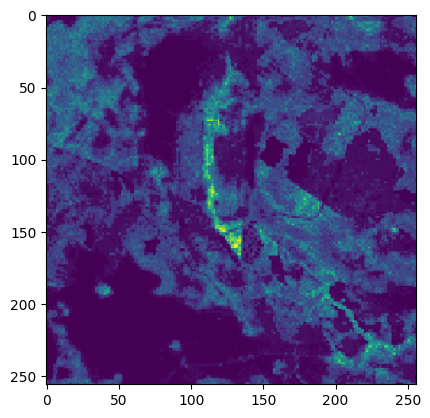

In [142]:
plt.imshow(y)

In [39]:
model.fit(datagen, epochs=100)

Epoch 1/100
4/4 [==============================] - 2s 484ms/step - loss: 5808.1729 - mean_squared_error: 5808.1729
Epoch 2/100
4/4 [==============================] - 2s 588ms/step - loss: 5154.6855 - mean_squared_error: 5154.6855
Epoch 3/100
4/4 [==============================] - 2s 497ms/step - loss: 4368.5479 - mean_squared_error: 4368.5479
Epoch 4/100
4/4 [==============================] - 2s 497ms/step - loss: 4128.1616 - mean_squared_error: 4128.1616
Epoch 5/100
4/4 [==============================] - 2s 532ms/step - loss: 3825.5264 - mean_squared_error: 3825.5264
Epoch 6/100
4/4 [==============================] - 2s 566ms/step - loss: 3759.4475 - mean_squared_error: 3759.4475
Epoch 7/100
4/4 [==============================] - 2s 465ms/step - loss: 3536.3560 - mean_squared_error: 3536.3560
Epoch 8/100
4/4 [==============================] - 2s 522ms/step - loss: 3407.5283 - mean_squared_error: 3407.5283
Epoch 9/100
4/4 [==============================] - 2s 474ms/step - loss: 3377.10

KeyboardInterrupt: 

In [20]:
predictions = model.predict(x)
predictions

1/1 [==============================] - 2s 2s/step


array([[24.545614  , 24.423998  , 12.995676  , ..., 68.99007   ,
        69.82352   , 42.806007  ],
       [ 9.152801  ,  9.131191  ,  7.291359  , ..., 22.497232  ,
        44.79737   , 66.996185  ],
       [ 0.7068986 ,  0.7366911 , -0.21179548, ...,  2.9021392 ,
         1.5630075 ,  1.531954  ],
       [36.851482  , 36.908455  , 56.154686  , ..., 50.077312  ,
        48.569073  , 44.919636  ]], dtype=float32)

In [21]:
predictions = predictions.reshape(4, 256, 256)

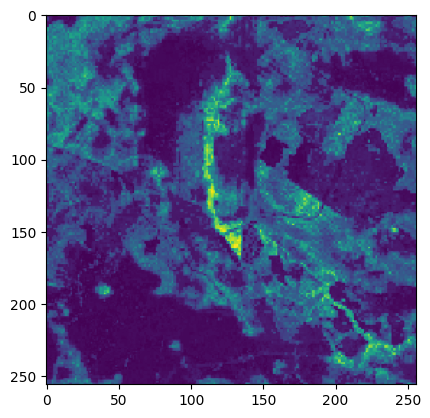

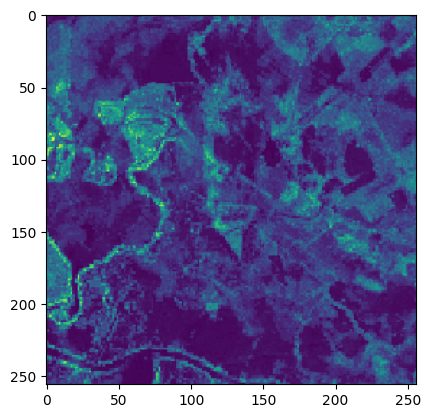

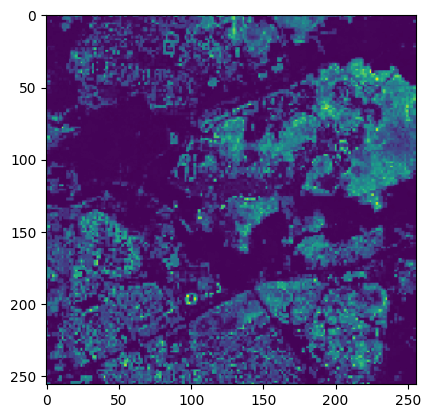

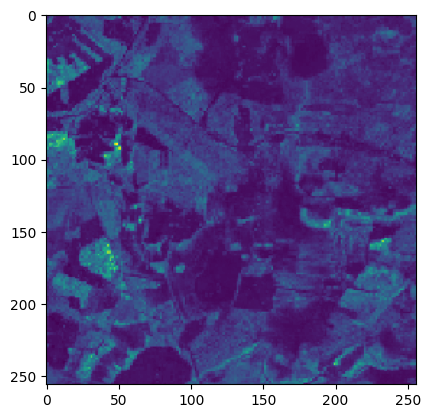

In [22]:
for pred in predictions:
    plt.imshow(pred)
    plt.show()

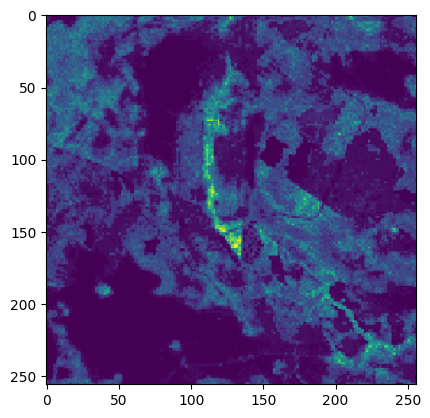

In [41]:
y = y.reshape(1, 256, 256)
for i in y:
    plt.imshow(i)
    plt.show()

In [16]:
import sys

In [62]:
class DataGeneratorNpy(tf.keras.utils.Sequence):
    def __init__(self, patch_ids, batch_size=3):
        """
        Few things to mention:
            - The data generator tells our model how to fetch one batch of training data (in this case from files)
            - Any work that can be done before training, should be done in init, since we want fetching a batch to be fast
            - Therefore, we want all filenames and labels to be determined before training
            - This saves work, because we will be fetching batches multiple times (across epochs)
        """
        self.dir_path = r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\test/'
        # Get all filenames in directory
        self.patches = patch_ids
        # Include batch size as attribute
        self.batch_size = batch_size

    def __len__(self):
        """
        Should return the number of BATCHES the generator can retrieve (partial batch at end counts as well)
        """
        return int(np.ceil(len(self.patches) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Tells generator how to retrieve BATCH idx
        """

        # Get filenames for X batch
        batch_patches = self.patches[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = [self.dir_path + p + '/label.npy' for p in batch_patches]

        batch_x = []
        batch_y = []
        for label_npy in batch_labels:
            label = np.load(label_npy).reshape(256 * 256)
            batch_y.append(label)

        #For batch in patches moet hier nog bij
        for p in batch_patches:
            s2_patch = []
            for month in range(12):
                s2_month = []
                try:
                    bands = [osp.join(self.dir_path + p + f'/{month}/S2/', file) for file in os.listdir(self.dir_path + p + f'/{month}/S2')]
                except:
                    continue
                for band in bands:
                    s2_month.append(np.load(band))

                s2_patch.append(s2_month)
            average = np.average(s2_patch, axis=0)
            average = average.reshape(256, 256, 11)
            batch_x.append(average)

        return np.asarray(batch_x), np.asarray(batch_y)

In [63]:
test = DataGeneratorNpy(patch_names)
x, y = test[0]

In [64]:
y.shape

(3, 65536)

In [31]:
for i in p:
    for month in range(12):
        for file in os.listdir(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\test/' + i + f'/{month}/S2'):
            print(file)

FileNotFoundError: [WinError 3] Het systeem kan het opgegeven pad niet vinden: 'C:\\Users\\kuipe\\OneDrive\\Bureaublad\\Epoch\\forestbiomass\\data\\test/000aa810/0/S2'

In [33]:
try:
    test = os.listdir(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\test/000aa810/0/S1')
except:
    test = None

print(test)

['0.npy', '1.npy', '2.npy', '3.npy']
